<a href="https://colab.research.google.com/github/Welwi/RL_typo/blob/master/RL_typo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I am training a RL algorithm that will master two varying envs with varying complexity.

ENV 1: Cartpole
The goal is to balance a pole, portruding from a cart, in an upright position by only movign the base left or right. This is an env with a low-dimensional observation space.

ENV2: Pong
The goal is to beat the competition. The env has a high-dimensional observation space - learning directly from raw pixels.

In [1]:

!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

!pip install mitdeeplearning

     |████████████████████████████████| 2.1MB 2.8MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=72d686830db44979b62ac7ed8df5c10c7557401505de07c12d6e2274163e385d
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


## Steps of RL probs in general:
1. Initialize the env and the agent: describe the different observations and actions the agent can make in the env.

2. Define the agent's memory: this will enable the agent to remember its past actions, observations and rewards

3. Define a reward function: describes the reward associated with an action or sequence of actions

4. Define the learning algorithm: this is used to reinforce the agent's good behavior and discourage the bad behaviors.

In [2]:
import tensorflow as tf
import numpy as np

import base64, io, time, gym
import IPython, functools

import matplotlib.pyplot as plt

from tqdm import tqdm

import mitdeeplearning as mdl

## PART 1: CARTPOLE

Gym is a toolkit that has several pre-defined environments for training and testing RL learning agents.

In Cartpole, the pole starts upright and the goal is to prevent it from falling. A reward of +1 is given for every timestep that the pole remains upright.
A reward of -1 is given if the the pole is more than 15 degrees from the vertical or if the cart moves more than 2.4 units from the center of the track.

In [3]:
# Instantiating the cartpole env

env = gym.make('CartPole-v0')
env.seed(1)

[1]

Observations that help define the env:
1. cart position
2. cart velocity
3. pole angle
4. pole rotation rate

Actions that the agent can take:
- The agent can move either right or left.

This shows that this is a low-dimensional observation and action spaces.

In [4]:
# Checking the size of the space
n_observations = env.observation_space
print('Env has observation space =', n_observations)

# Checking the num of actions that the agent can take
n_actions = env.action_space.n
print('Num of possible actions that the agent can choose from =', n_actions)

Env has observation space = Box(4,)
Num of possible actions that the agent can choose from = 2


In [5]:
n_actions

2

### Defining the agent

In RL, a deep neural network defines the agent.
This network takes in an observation of the environment, and outputs the probability of taking each of the possible actions.
Since this is a low dimensional observation space, we can use a simple feed forward NN

In [6]:
# Defining the carpole agent
def create_carpole_model():

  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(units=32, activation='relu'),
                                      tf.keras.layers.Dense(units=n_actions, activation= None)
  ])

  return model

cartpole_model = create_carpole_model()

Defining a feed forward pass through the network (action function)

- takes observations as inputs
- does a forward pass through the model
- outputs the agent action


In [7]:
def choose_action(model, observation):

  # adding the batch dimension to the observation
  observation = np.expand_dims(observation, axis=0)

  # passing the observation through the model
  logits = model.predict(observation)

  # pass the probabilities through softmax to get true probability
  prob_weights = tf.nn.softmax(logits).numpy()

  # random selection of an action from observation
  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

  return action

## Agents Memory

Unables agent to remember past actions, observations and rewards.

In RL:
- Training happens alongside the agent's acting in the env
- Episode: sequence of actions that ends in a terminal state (pole falling or cart crashing)
- The agent needs to remember all of the observations and actions for the episode to reinforce or punish the actions.

In [8]:
class Memory:
  def __init__(self):
    self.clear()

  # reseting the memory buffer
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []

  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)

memory = Memory()

## Rewards function

For this case, we are focusing on giving preference to rewards that happen now than in the future.

To implement function:
- initialize an array of zeros  with length of the number of time steps
- fill it with the discounted reward values as we look through the rewards from the episode
- To find out which actions are better - normalize the rewards using the mean and std of the rewards across the learning episode.

In [9]:
# Function to normalize the rewards
def normalize(x):
   
   x -= np.mean(x)
   x /= np.std(x)
   return x.astype(np.float32)

In [20]:
def discount_rewards(rewards, gamma=0.95):

  #initializing an array of zeros
  discounted_rewards = np.zeros_like(rewards)

  R = 0
  for t in reversed(range(0, len(rewards))):
    R = R*gamma + rewards[t]

    discounted_rewards[t] = R

    return normalize(discounted_rewards)


## Defining the Learning algorithm

For this exercise the focus is going to be policy gradient methods which aim to maximize the likelihood of actions that result in large rewards

This can be done by scaling the probabilities by the associated rewards. This results in amplifying the likelihood of actions that result in large rewards.

This means that to minimize the negative likelihood is equivalent to minimizing the negative log-likelihood which can be done using softmax cross entropy.

In [21]:
def compute_loss (logits, actions, rewards):

  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits= logits,
                                                               labels = actions)
  loss = tf.reduce_mean(neg_logprob * rewards)

  return loss


## Defining the training step

In [25]:
def train_step(model, optimizer, observations, actions, discounted_rewards):

  with tf.GradientTape() as tape:
    logits = model(observations)

    loss = compute_loss(logits, actions, discounted_rewards)
  
  # backpropagation to minimize the loss
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Running the Cartpole

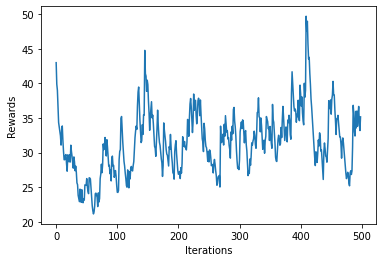

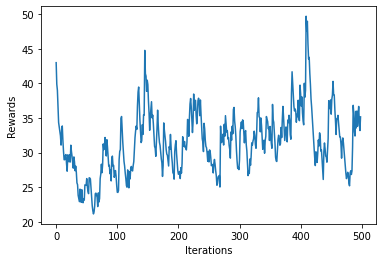

In [26]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiating the cartpole agent
cartpole_model = create_carpole_model()

# to track progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel = 'Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for i_episode in range(500):

  plotter.plot(smoothed_reward.get())

  # Restart the env
  observation = env.reset()
  memory.clear()

  while True:
    # using our obsrevation, choose an action and take it in the env
    action = choose_action(cartpole_model, observation)
    next_observation, reward, done, info = env.step(action)

    # add to memory
    memory.add_to_memory(observation, action, reward)

    if done:
      # determine total reward and keep a record of this
      total_reward = sum(memory.rewards)
      smoothed_reward.append(total_reward)

      train_step(cartpole_model, optimizer, 
                 observations=np.vstack(memory.observations),
                 actions=np.array(memory.actions),
                 discounted_rewards = discount_rewards(memory.rewards))
      
      # reset the memory
      memory.clear()
      break
    # update our observations
    observation = next_observation

In [24]:
1e-3

0.001

In [ ]:
test_rewards = [1,-1,-1,1,1,1,-1]

In [ ]:
disc_rewards = np.zeros_like(test_rewards)
disc_rewards

array([0, 0, 0, 0, 0, 0, 0])

In [ ]:
# using the cum reward formula
gamma = 0.95
R = 0
for t in range(0, len(test_rewards)):
  print(t)
  R = R*gamma + test_rewards[t]
  print(R)

0
1.0
1
-0.050000000000000044
2
-1.0475
3
0.004874999999999963
4
1.0046312499999999
5
1.9543996874999998
6
0.8566797031249997


## Breaking it down

In [ ]:
# resets the state of the env and returns an initial observation
observation = env.reset()

In [ ]:
observation

array([ 0.03073904,  0.00145001, -0.03088818, -0.03131252])

In [ ]:
observation.shape

(4,)

In [ ]:
# adding batch dimension to the obs
observation = np.expand_dims(observation, axis=0)

In [ ]:
observation.shape

(1, 4)

In [ ]:
# passing obs through the model
logits = cartpole_model(observation)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [ ]:
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00845183,  0.02072986]], dtype=float32)>

In [ ]:
  # pass the probabilities through softmax to get true probability
  prob_weights = tf.nn.softmax(logits).numpy()

In [ ]:
prob_weights

array([[0.49270508, 0.5072949 ]], dtype=float32)

In [ ]:
prob_weights.flatten()

array([0.49270508, 0.5072949 ], dtype=float32)

In [ ]:
prob_weights.shape

(1, 2)

In [ ]:
prob_weights.flatten().shape

(2,)

In [ ]:
action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())

In [ ]:
action

array([1])

In [ ]:
action[0]

1

In [ ]:
action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]